In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2024/Julia"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


[ Info: Precompiling PDMPFlux [fa921718-cbf9-4165-aaee-7047d51b02b3] (cache misses: include_dependency fsize change (2), wrong dep version loaded (2), invalid header (4))


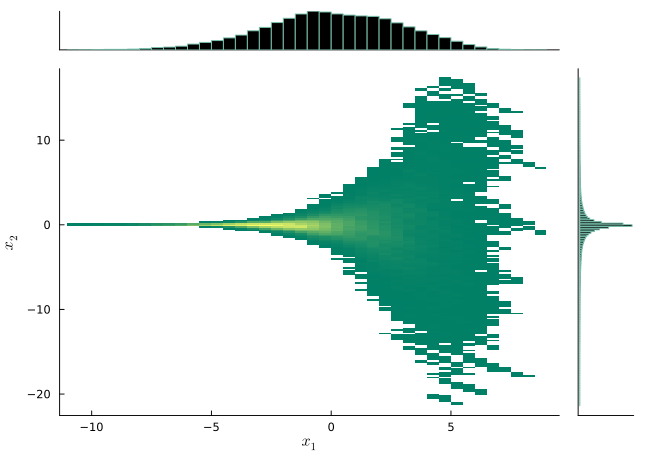

In [2]:
using PDMPFlux

using Random, Distributions, Plots, LaTeXStrings, Zygote, LinearAlgebra

"""
    Funnel distribution for testing. Returns energy and sample functions.
    For reference, see Neal, R. M. (2003). Slice sampling. The Annals of Statistics, 31(3), 705–767.
"""
function funnel(d::Int=10, σ::Float64=3.0, clip_y::Int=11)

    function neg_energy(x::Vector{Float64})
        v = x[1]
        log_density_v = logpdf(Normal(0.0, 3.0), v)
        variance_other = exp(v)
        other_dim = d - 1
        cov_other = I * variance_other
        mean_other = zeros(other_dim)
        log_density_other = logpdf(MvNormal(mean_other, cov_other), x[2:end])
        return - log_density_v - log_density_other
    end

    function sample_data(n_samples::Int)
        # sample from Nd funnel distribution
        y = clamp.(σ * randn(n_samples, 1), -clip_y, clip_y)
        x = randn(n_samples, d - 1) .* exp.(-y / 2)
        return hcat(y, x)
    end

    return neg_energy, sample_data
end

function plot_funnel(d::Int=10, n_samples::Int=10000)
    _, sample_data = funnel(d)
    data = sample_data(n_samples)

    # 最初の2次元を抽出（yとx1）
    y = data[:, 1]
    x1 = data[:, 2]

    # 散布図をプロット
    scatter(y, x1, alpha=0.5, markersize=1, xlabel=L"y", ylabel=L"x_1", 
            title="Funnel Distribution (First Two Dimensions' Ground Truth)", grid=true, legend=false, color="#78C2AD")

    # xlim と ylim を追加
    xlims!(-8, 8)  # x軸の範囲を -8 から 8 に設定
    ylims!(-7, 7)  # y軸の範囲を -7 から 7 に設定
end
plot_funnel()

function run_ZigZag_on_funnel(N_sk::Int=100_000, N::Int=100_000, d::Int=10, verbose::Bool=false)
    U, _ = funnel(d)
    grad_U(x::Vector{Float64}) = gradient(U, x)[1]
    xinit = ones(d)
    vinit = ones(d)
    seed = 2024
    grid_size = 0  # constant bounds
    sampler = ZigZag(d, grad_U, grid_size=grid_size)
    out = sample_skeleton(sampler, N_sk, xinit, vinit, seed=seed, verbose = verbose)
    samples = sample_from_skeleton(sampler, N, out)
    return out, samples
end
output, samples = run_ZigZag_on_funnel()  # ４分かかる

jointplot(samples)

In [3]:
using Zygote
gradient(x -> 3x^2 + 2x + 1, 5)

(32.0,)

In [4]:
f(x::Vector{Float64}) = 3x[1]^2 + 2x[2] + 1
g(x) = gradient(f,x)
g([1.0,2.0])

([6.0, 2.0],)

In [5]:
using Optim
f(x) = (x-1)^2
result = optimize(f, 0.0, 1.0)
result.minimizer

0.999999984947842